# Homework 3
Christopher Liu

In [254]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(threshold=np.inf) #set how many elements are displayed, default is 1000

## Loading Data 

In [255]:
x = loadmat('x_f.mat')

In [256]:
faces = np.asarray(x['X_f'])

In [257]:
faces_dm = faces - np.mean(faces,1).reshape((32256, 1))

## Compute the SVD

In [258]:
#Plot a rank-approximation of a face
def pltface(U,S,V,rank,num):
    img = (U[:,0:rank]*S[0:rank])@V[0:rank,num]
    plt.imshow(img.reshape(192,168, order='F'),cmap='gray')

In [259]:
U,S,VT = np.linalg.svd(faces,full_matrices=False)

## Constructing the labels

In [261]:
#number of pictures per person
pic_num = 64*np.ones(38)
pic_num[10] = 60
pic_num[11] = 59
pic_num[12] = 60
pic_num[13] = 63
pic_num[14] = 62
pic_num[15] = 63
pic_num[16] = 63

#individual # of each female

gender = [4,13,20,25,26,30,32,35]

In [262]:
#Create labels for all 38 individuals. 1-38
def ind_label_all(picn):
    labels = np.zeros(int(np.sum(picn)))
    
    for i in range(0,len(picn)):
        ind = int(np.sum(picn[0:i])) 
        numpic = picn[i]
        labels[ind:int(ind+numpic)] = 1*(i+1)        

    return labels

In [263]:
ind_labels = ind_label_all(pic_num)

In [264]:
#Create labels for gender, 0 for male, 1 for female
def gen_label(gender,picn):
    gen_labels = np.zeros(int(np.sum(picn)))
    
    for i in range(0,len(gender)):
        individual = int(gender[i])
        ind = int(np.sum(picn[0:individual]))
        numpic = int(picn[individual])
        
        gen_labels[ind:ind+numpic] = 1
        
    return gen_labels

In [265]:
gen_labels = gen_label(gender,pic_num)

## Separate into test and training data/labels

In [266]:
#Separates the data and labels into training and tests sets for a given random seed. 
def testtrain(data,labels,picn,seed):
    np.random.seed(seed)
    train = np.array([])
    test = np.array([])
    train_label = np.array([])
    test_label = np.array([])
    
    for i in range(0,len(picn)):
        tt = int(np.round(0.2*picn[i]))
        tr = int(picn[i]-tt)
        ind = int(np.sum(picn[0:i])) 
        
        perm = np.random.permutation(int(pic_num[i]))
        tr_ind = perm[0:tr] + ind
        tt_ind = perm[tr:] + ind
        
        train = np.hstack([train, data[:,tr_ind]]) if train.size else data[:,tr_ind]
        train_label = np.hstack([train_label, labels[tr_ind]]) if train_label.size else labels[tr_ind]
        
        test = np.hstack([test,data[:,tt_ind]]) if test.size else data[:,tt_ind]
        test_label= np.hstack([test_label,labels[tt_ind]]) if test_label.size else labels[tt_ind]
        
    return train, test, train_label, test_label

In [267]:
#Lists containing the training and testing data/labels for individuals and gender
train_ind = []
test_ind = []
train_label_ind = []
test_label_ind = []

train_gen = []
test_gen = []
train_label_gen = []
test_label_gen = []

In [268]:
#Populate the above lists with 5 training/test sets for gender and invididual classification. Each different set is created
#by passing a different random seed.
for i in range(0,5):
    train, test, train_label, test_label = testtrain(VT,ind_labels,pic_num,i+1)
    
    train_ind.append(train)
    test_ind.append(test)
    train_label_ind.append(train_label)
    test_label_ind.append(test_label)
    
    gtrain, gtest, gtrain_label, gtest_label = testtrain(VT,gen_labels,pic_num,i+1)
    
    train_gen.append(gtrain)
    test_gen.append(gtest)
    train_label_gen.append(gtrain_label)
    test_label_gen.append(gtest_label)

## Classification

In [270]:
#averages a list of numpy 1-d arrays 
def avg(list2d):
    sum = np.asarray(list2d[0])
    for i in range(1,len(list2d)):
        sum = sum + np.asarray(list2d[i])
    return sum/len(list2d)

In [271]:
ranks = np.linspace(25,500,20,dtype=int)

## Classifying Individuals

In [272]:
ind_acc = []

### K-nearest neighbors

In [273]:
from sklearn.neighbors import KNeighborsClassifier

In [274]:
neigh = KNeighborsClassifier(n_neighbors=5)
knn_ind = []

for j in range(0,len(train_ind)):
    knn_rank_acc = []
    
    train = train_ind[j]
    test = test_ind[j]
    train_label = train_label_ind[j]
    test_label = test_label_ind[j]

    for i in range(0,len(ranks)):
        neigh.fit(train[0:ranks[i],:].T, train_label)
        knn_rank_acc.append(neigh.score(test[0:ranks[i],:].T,test_label))
    
    knn_ind.append(knn_rank_acc)

Text(0, 0.5, 'Accuracy')

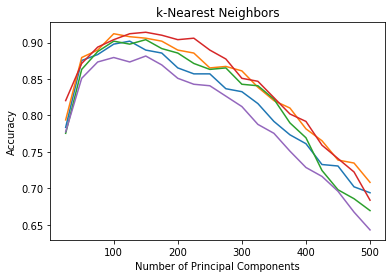

In [275]:
for i in range(0,len(knn_ind)):
    plt.plot(ranks,knn_ind[i])

plt.title('k-Nearest Neighbors')
plt.xlabel('Number of Principal Components')
plt.ylabel('Accuracy')

In [276]:
ind_acc.append(avg(knn_ind))

### Linear Discriminant Analysis

In [277]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [278]:
clf = LinearDiscriminantAnalysis()
lda_ind = []

for j in range(0,len(train_ind)):
    lda_rank_acc = []
    
    train = train_ind[j]
    test = test_ind[j]
    train_label = train_label_ind[j]
    test_label = test_label_ind[j]    

    for i in range(0,len(ranks)):
        clf.fit(train[0:ranks[i],:].T, train_label)
        lda_rank_acc.append(clf.score(test[0:ranks[i],:].T, test_label))
    
    lda_ind.append(lda_rank_acc)

Text(0, 0.5, 'Accuracy')

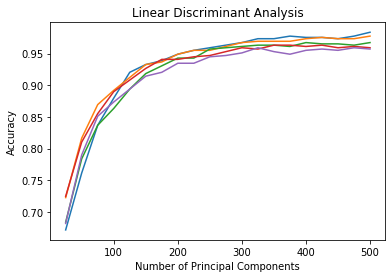

In [279]:
for i in range(0,len(lda_ind)):
    plt.plot(ranks,lda_ind[i])

plt.title('Linear Discriminant Analysis')
plt.xlabel('Number of Principal Components')
plt.ylabel('Accuracy')

In [280]:
ind_acc.append(avg(lda_ind))

### SVM

In [281]:
from sklearn.svm import SVC

In [282]:
svm_clf = SVC(kernel='rbf',gamma='scale')

svm_ind = []

for j in range(0,len(train_ind)):
    svm_rank_acc = []
    
    train = train_ind[j]
    test = test_ind[j]
    train_label = train_label_ind[j]
    test_label = test_label_ind[j]   

    for i in range(0,len(ranks)):
        svm_clf.fit(train[0:ranks[i],:].T, train_label)
        svm_rank_acc.append(svm_clf.score(test[0:ranks[i],:].T, test_label))

    svm_ind.append(svm_rank_acc)

Text(0, 0.5, 'Accuracy')

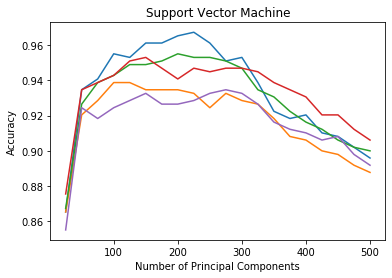

In [283]:
for i in range(0,len(svm_ind)):
    plt.plot(ranks,svm_ind[i])

plt.title('Support Vector Machine')
plt.xlabel('Number of Principal Components')
plt.ylabel('Accuracy')

In [284]:
ind_acc.append(avg(svm_ind))

### Naive Bayes

In [285]:
from sklearn.naive_bayes import GaussianNB

In [286]:
nb_clf = GaussianNB()

nb_ind = []

for j in range(0,len(train_ind)):
    nb_rank_acc = []
    
    train = train_ind[j]
    test = test_ind[j]
    train_label = train_label_ind[j]
    test_label = test_label_ind[j]   

    for i in range(0,len(ranks)):
        nb_clf.fit(train[0:ranks[i],:].T, train_label)
        nb_rank_acc.append(nb_clf.score(test[0:ranks[i],:].T, test_label))

    nb_ind.append(nb_rank_acc)

Text(0, 0.5, 'Accuracy')

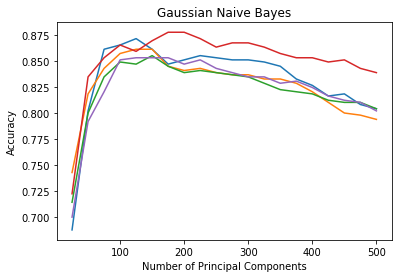

In [287]:
for i in range(0,len(nb_ind)):
    plt.plot(ranks,nb_ind[i])

plt.title('Gaussian Naive Bayes')
plt.xlabel('Number of Principal Components')
plt.ylabel('Accuracy')

In [288]:
ind_acc.append(avg(nb_ind))

### Decision Tree

In [289]:
from sklearn import tree

In [290]:
tree_clf = tree.DecisionTreeClassifier()

tree_ind = []

for j in range(0,len(train_ind)):
    tree_rank_acc = []
    
    train = train_ind[j]
    test = test_ind[j]
    train_label = train_label_ind[j]
    test_label = test_label_ind[j]   
    
    for i in range(0,len(ranks)):
        tree_clf.fit(train[0:ranks[i],:].T, train_label)
        tree_rank_acc.append(tree_clf.score(test[0:ranks[i],:].T, test_label))

    tree_ind.append(tree_rank_acc)

Text(0, 0.5, 'Accuracy')

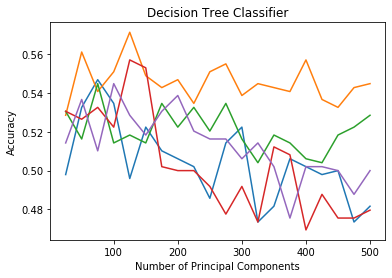

In [291]:
for i in range(0,len(tree_ind)):
    plt.plot(ranks,tree_ind[i])

plt.title('Decision Tree Classifier')
plt.xlabel('Number of Principal Components')
plt.ylabel('Accuracy')

In [292]:
ind_acc.append(avg(tree_ind))

### Compare All

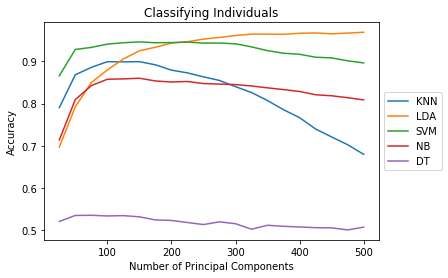

In [293]:
for i in range(0,len(ind_acc)):
    plt.plot(ranks,ind_acc[i])
    
plt.legend(['KNN', "LDA", "SVM", "NB", "DT"],loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Number of Principal Components')
plt.ylabel('Accuracy')
plt.title('Classifying Individuals')

plt.savefig('class_ind.png')

## Gender Classification

In [294]:
gen_acc = []

### K-nearest neighbors

In [295]:
neigh = KNeighborsClassifier(n_neighbors=5)
knn_gen = []

for j in range(0,len(train_gen)):
    knn_rank_acc = []
    
    train = train_gen[j]
    test = test_gen[j]
    train_label = train_label_gen[j]
    test_label = test_label_gen[j]

    for i in range(0,len(ranks)):
        neigh.fit(train[0:ranks[i],:].T, train_label)
        knn_rank_acc.append(neigh.score(test[0:ranks[i],:].T,test_label))
    
    knn_gen.append(knn_rank_acc)

Text(0, 0.5, 'Accuracy')

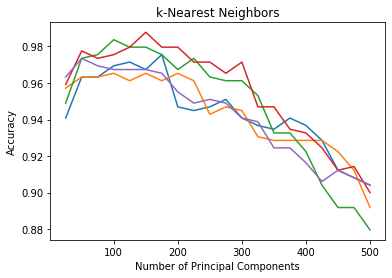

In [296]:
for i in range(0,len(knn_gen)):
    plt.plot(ranks,knn_gen[i])

plt.title('k-Nearest Neighbors')
plt.xlabel('Number of Principal Components')
plt.ylabel('Accuracy')

In [297]:
gen_acc.append(avg(knn_gen))

### Linear Discriminant Analysis

In [298]:
clf = LinearDiscriminantAnalysis()
lda_gen = []

for j in range(0,len(train_gen)):
    lda_rank_acc = []
    
    train = train_gen[j]
    test = test_gen[j]
    train_label = train_label_gen[j]
    test_label = test_label_gen[j]    

    for i in range(0,len(ranks)):
        clf.fit(train[0:ranks[i],:].T, train_label)
        lda_rank_acc.append(clf.score(test[0:ranks[i],:].T, test_label))
    
    lda_gen.append(lda_rank_acc)

Text(0, 0.5, 'Accuracy')

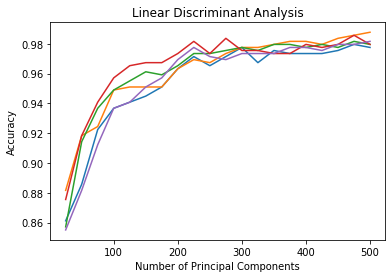

In [299]:
for i in range(0,len(lda_gen)):
    plt.plot(ranks,lda_gen[i])

plt.title('Linear Discriminant Analysis')
plt.xlabel('Number of Principal Components')
plt.ylabel('Accuracy')

In [300]:
gen_acc.append(avg(lda_gen))

### Support Vector Machine

In [301]:
svm_clf = SVC(kernel='rbf',gamma='scale')

svm_gen = []

for j in range(0,len(train_gen)):
    svm_rank_acc = []
    
    train = train_gen[j]
    test = test_gen[j]
    train_label = train_label_gen[j]
    test_label = test_label_gen[j]   

    for i in range(0,len(ranks)):
        svm_clf.fit(train[0:ranks[i],:].T, train_label)
        svm_rank_acc.append(svm_clf.score(test[0:ranks[i],:].T, test_label))

    svm_gen.append(svm_rank_acc)

Text(0, 0.5, 'Accuracy')

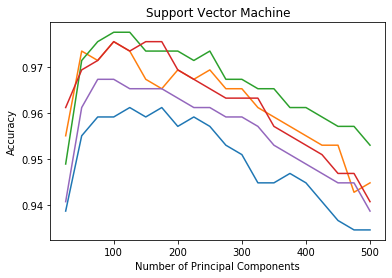

In [302]:
for i in range(0,len(svm_gen)):
    plt.plot(ranks,svm_gen[i])

plt.title('Support Vector Machine')
plt.xlabel('Number of Principal Components')
plt.ylabel('Accuracy')

In [303]:
gen_acc.append(avg(svm_gen))

### Naive Bayes

In [304]:
nb_clf = GaussianNB()

nb_gen = []

for j in range(0,len(train_ind)):
    nb_rank_acc = []
    
    train = train_gen[j]
    test = test_gen[j]
    train_label = train_label_gen[j]
    test_label = test_label_gen[j]   

    for i in range(0,len(ranks)):
        nb_clf.fit(train[0:ranks[i],:].T, train_label)
        nb_rank_acc.append(nb_clf.score(test[0:ranks[i],:].T, test_label))

    nb_gen.append(nb_rank_acc)

Text(0, 0.5, 'Accuracy')

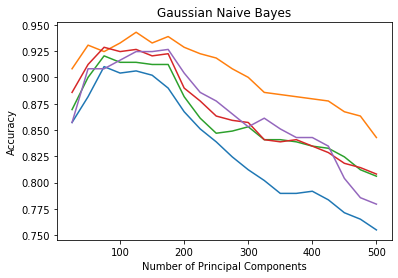

In [305]:
for i in range(0,len(nb_gen)):
    plt.plot(ranks,nb_gen[i])

plt.title('Gaussian Naive Bayes')
plt.xlabel('Number of Principal Components')
plt.ylabel('Accuracy')

In [306]:
gen_acc.append(avg(nb_gen))

### Decision Tree

In [307]:
tree_clf = tree.DecisionTreeClassifier()

tree_gen = []

for j in range(0,len(train_gen)):
    tree_rank_acc = []
    
    train = train_gen[j]
    test = test_gen[j]
    train_label = train_label_gen[j]
    test_label = test_label_gen[j]   
    
    for i in range(0,len(ranks)):
        tree_clf.fit(train[0:ranks[i],:].T, train_label)
        tree_rank_acc.append(tree_clf.score(test[0:ranks[i],:].T, test_label))

    tree_gen.append(tree_rank_acc)

Text(0, 0.5, 'Accuracy')

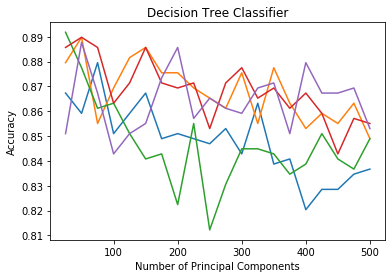

In [308]:
for i in range(0,len(tree_gen)):
    plt.plot(ranks,tree_gen[i])

plt.title('Decision Tree Classifier')
plt.xlabel('Number of Principal Components')
plt.ylabel('Accuracy')

In [309]:
gen_acc.append(avg(tree_gen))

### Compare All

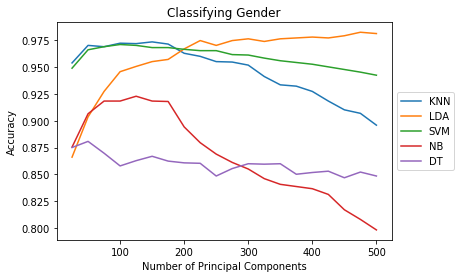

In [310]:
for i in range(0,len(gen_acc)):
    plt.plot(ranks,gen_acc[i])
    
plt.legend(['KNN', "LDA", "SVM", "NB", "DT"],loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Number of Principal Components')
plt.ylabel('Accuracy')
plt.title('Classifying Gender')

plt.savefig('class_gen.png')

## Unsupervised 

### K-means Clustering

In [319]:
from sklearn.cluster import KMeans

kmeans2 = KMeans(n_clusters=2, random_state=0).fit(faces.T)

In [328]:
kmeans4  = KMeans(n_clusters=4, random_state=0).fit(faces.T)

### Plotting and Comparing

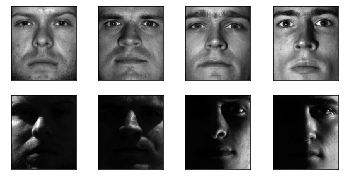

In [407]:
#k-means = 2
plt.figure(figsize=(6,3))

plt.subplot(2,4,1)
plt.imshow(faces[:,0].reshape(192,168, order='F'),cmap='gray')
plt.xticks([])
plt.yticks([])

plt.subplot(2,4,2)
plt.imshow(faces[:,228].reshape(192,168, order='F'),cmap='gray')
plt.xticks([])
plt.yticks([])

plt.subplot(2,4,3)
plt.imshow(faces[:,1078].reshape(192,168, order='F'),cmap='gray')
plt.xticks([])
plt.yticks([])

plt.subplot(2,4,4)
plt.imshow(faces[:,1722].reshape(192,168, order='F'),cmap='gray')
plt.xticks([])
plt.yticks([])

plt.subplot(2,4,5)
plt.imshow(faces[:,30].reshape(192,168, order='F'),cmap='gray')
plt.xticks([])
plt.yticks([])

plt.subplot(2,4,6)
plt.imshow(faces[:,252].reshape(192,168, order='F'),cmap='gray')
plt.xticks([])
plt.yticks([])

plt.subplot(2,4,7)
plt.imshow(faces[:,1067].reshape(192,168, order='F'),cmap='gray')
plt.xticks([])
plt.yticks([])

plt.subplot(2,4,8)
plt.imshow(faces[:,2023].reshape(192,168, order='F'),cmap='gray')
plt.xticks([])
plt.yticks([])

plt.savefig('kmeans2.png')

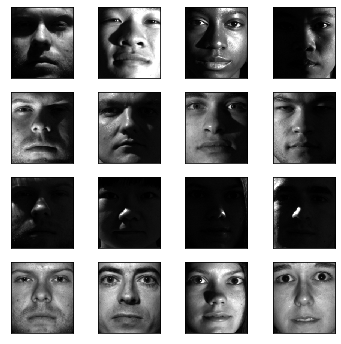

In [392]:
#k-means = 4
plt.figure(figsize=(6,6))

plt.subplot(4,4,1)
plt.imshow(faces[:,46].reshape(192,168, order='F'),cmap='gray')
plt.xticks([])
plt.yticks([])

plt.subplot(4,4,2)
plt.imshow(faces[:,805].reshape(192,168, order='F'),cmap='gray')
plt.xticks([])
plt.yticks([])

plt.subplot(4,4,3)
plt.imshow(faces[:,1310].reshape(192,168, order='F'),cmap='gray')
plt.xticks([])
plt.yticks([])

plt.subplot(4,4,4)
plt.imshow(faces[:,2279].reshape(192,168, order='F'),cmap='gray')
plt.xticks([])
plt.yticks([])

plt.subplot(4,4,5)
plt.imshow(faces[:,20].reshape(192,168, order='F'),cmap='gray')
plt.xticks([])
plt.yticks([])

plt.subplot(4,4,6)
plt.imshow(faces[:,408].reshape(192,168, order='F'),cmap='gray')
plt.xticks([])
plt.yticks([])

plt.subplot(4,4,7)
plt.imshow(faces[:,1026].reshape(192,168, order='F'),cmap='gray')
plt.xticks([])
plt.yticks([])

plt.subplot(4,4,8)
plt.imshow(faces[:,2309].reshape(192,168, order='F'),cmap='gray')
plt.xticks([])
plt.yticks([])

plt.subplot(4,4,9)
plt.imshow(faces[:,31].reshape(192,168, order='F'),cmap='gray')
plt.xticks([])
plt.yticks([])

plt.subplot(4,4,10)
plt.imshow(faces[:,286].reshape(192,168, order='F'),cmap='gray')
plt.xticks([])
plt.yticks([])

plt.subplot(4,4,11)
plt.imshow(faces[:,1708].reshape(192,168, order='F'),cmap='gray')
plt.xticks([])
plt.yticks([])

plt.subplot(4,4,12)
plt.imshow(faces[:,2384].reshape(192,168, order='F'),cmap='gray')
plt.xticks([])
plt.yticks([])

plt.subplot(4,4,13)
plt.imshow(faces[:,0].reshape(192,168, order='F'),cmap='gray')
plt.xticks([])
plt.yticks([])

plt.subplot(4,4,14)
plt.imshow(faces[:,330].reshape(192,168, order='F'),cmap='gray')
plt.xticks([])
plt.yticks([])

plt.subplot(4,4,15)
plt.imshow(faces[:,1693].reshape(192,168, order='F'),cmap='gray')
plt.xticks([])
plt.yticks([])

plt.subplot(4,4,16)
plt.imshow(faces[:,2066].reshape(192,168, order='F'),cmap='gray')
plt.xticks([])
plt.yticks([])

plt.savefig('kmeans4.png')